# Script 1: Fitting an Eclipsing Binary with Estimators

First we will start by using the geometry of the radial velocity curves and light curves to obtain initial estimates for several of the parameters. This part is fast as we are not createing a mesh for the stars but the estimated parameters can perscribe a system that is not physical. 

For this notbook you will need:
* light curve data
* radial velocity data
* the temperature of one star (usually we know the temperature of the more luminous star)
* the period of the system and zero point in time (the zero point and data sets must be in the same time units, i.e., BJD or TBJD)
    

First, we will import all the necessary modules including PHOEBE

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import phoebe
import scipy
phoebe.multiprocessing_off()
logger = phoebe.logger()
%matplotlib inline

Generate a "bundle" that will contain all the binary star information:

In [2]:
b = phoebe.default_binary()

Load your light curves and add them to the bundle. As light curves generally have lots of points, it is better to specify "compute phases". These are the phases for which a model will be computed. Without this the model will be computed for each data point - this would take a loooonngg time:

For this part, I use a heavily detrended light curve (this star has significant variations due to spots) because the estimators and optimizers would have a hard time fitting these variations. When applying McMC with Gaussian Processes, I will use a less detrended light curve. 

In [3]:
lc = np.loadtxt('data/detrended_aggressive.dat')
b.add_dataset('lc', times=lc[:,0], fluxes=lc[:,1], sigmas=lc[:,2], compute_phases=phoebe.linspace(0,1,101), passband='Kepler:mean', dataset='lc01', overwrite=True)

<ParameterSet: 80 parameters | contexts: dataset, compute, constraint, figure>

Load the radial velocity data and add to the bundle. For the RVs, the primary rv should be for the HOTTER star and the secondary for the COOLER star.

In [4]:
rv1 = np.loadtxt('data/rv_hot.dat')
rv2 = np.loadtxt('data/rv_cold.dat')
b.add_dataset('rv')
b['times@rv@primary'], b['rvs@rv@primary'], b['sigmas@rv@primary'] = rv1[:,0], rv1[:,1], rv1[:,2]
b['times@rv@secondary'], b['rvs@rv@secondary'], b['sigmas@rv@secondary'] = rv2[:,0], rv2[:,1], rv2[:,2]

Update the period of the binary star with the known period, the zeropoint of the data (ensure it is close to both the RV times and the LC times) and the effective temperature of the more luminous star (three different ways to update parameters are shown here):

In [5]:
teff_rg = 5042 #temperature of the red giant (the cooler, secondary star)
b['teff@secondary@star@component'] = teff_rg

period = 63.32710558 #orbital period
b.get_parameter(context='component', kind='orbit', qualifier='period').set_value(period)

ztime = 54976.635546+20*period #zero point such that it is within both rv and lc temporal ranges
b.set_value(qualifier='t0_supconj', value=ztime)

Plot the radial velocity curve and the light curve:

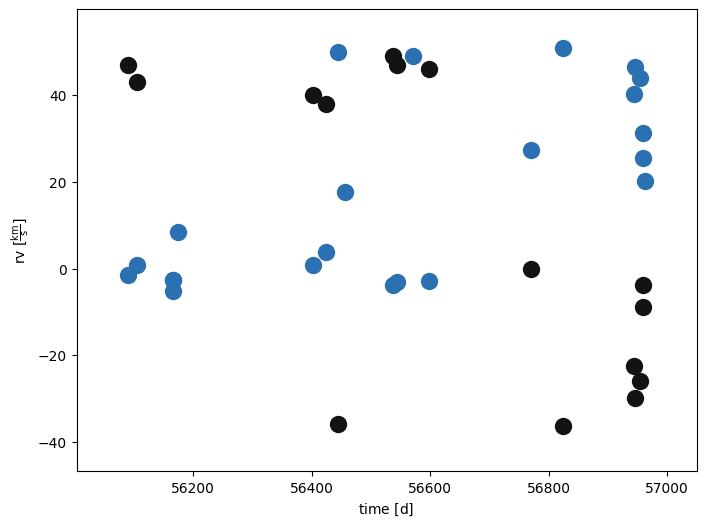

/usr/local/lib/python3.10/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


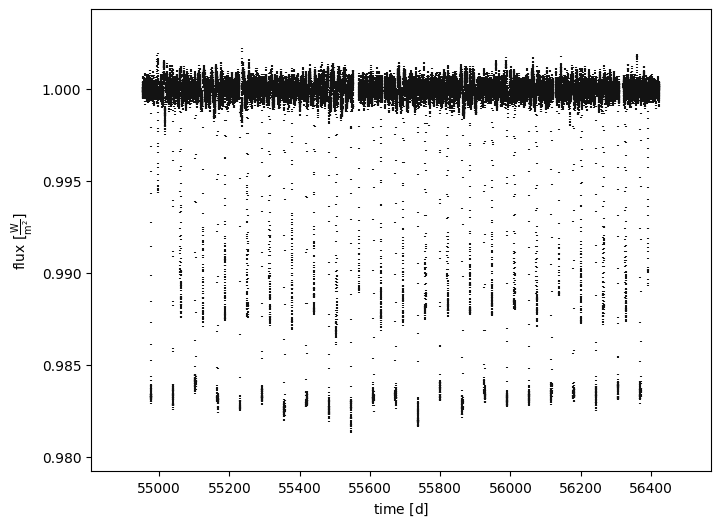

In [6]:
r = b.plot(dataset='rv01',show=True, marker='o')
l = b.plot(dataset='lc01',show=True, marker='+')

Plot the phased radial velocity and light curves:

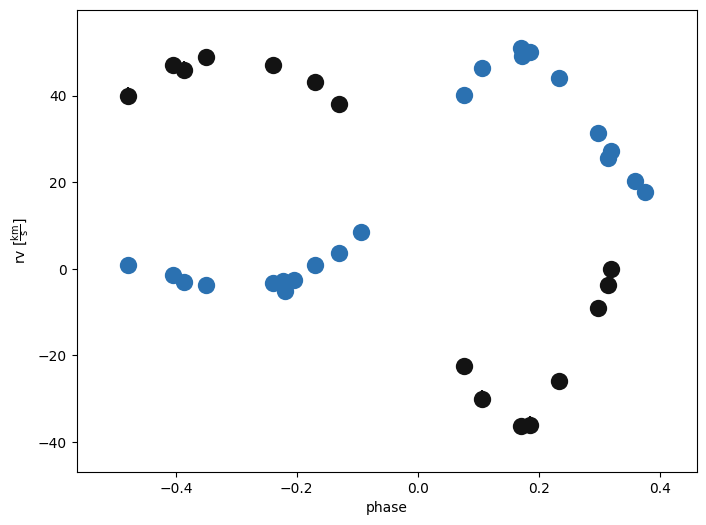

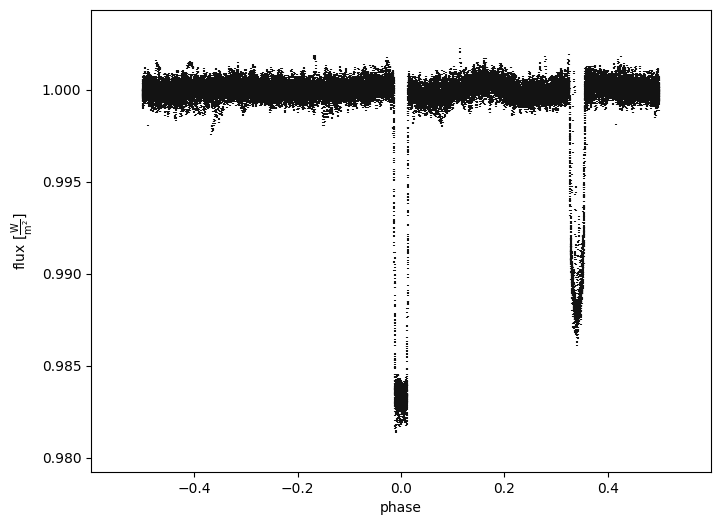

In [7]:
r2 = b.plot(x='phase',dataset='rv01',show=True, marker='o')
l2 = b.plot(x='phase',dataset='lc01',show=True, marker='+')

# Prepare the model parameters for swift initial computations

Before we start, let's adjust the model parameters so that the computations are fast. We will update these parameters to include all the detailed physics later.

Set the passband luminosity calculations to scale to the data (we will update this to component coupled later):

In [8]:
b.set_value('pblum_mode', 'dataset-scaled')

Let's assume the stars are spheres, this significantly reduces the computation time when the system has an eccentric orbit (we'll change this back later):

In [9]:
b.set_value_all('distortion_method', 'sphere')

Now we set the atmosphere parameters to be blackbody and to be adjusted manually. This avoids errors from being outside the atmosphere tables (We do this now since the estimators can produce unphysical results):


In [ ]:
b.set_value_all('atm', 'blackbody')
b.set_value_all('ld_mode', 'manual')
b.set_value_all('ld_mode_bol', 'manual')

# Use the geometry of the radial velocity curve to estimate the parameters

First we apply the radial velocity estimator. The purpose of this is to obtain *initial estimates* for the radial velocity parameters, specifically: the zeropoint (relative to the initial one we provided earlier), the mass ratio, asini, the orbital eccentricity and argument of periastron and the systemic (gamma) velocity.

First, we make sure the parameters are set up for the RV estimator (and to speed up the computation of the model). To do this, we set equivalent radii (requivs) so that overflow (of matter between the two stars) does not occur. We do this by making them relatively small. Also note that in this example the primary has a smaller radius - again, the red giant is the secondary and the main sequence star is the primary (selection is based on temperature - the primary star is the hotter star).

In [ ]:
b['requiv@primary@star@component'] = 0.7
b['requiv@secondary@star@component'] = 5.

As the radial velocity estimator accepts asini, the semi-major axis * sin (inclination), as a parameter, we must change the parameters (flip the constraints) so that asini is adjustable and the semi-major axis (sma) value updates automatically. 

In [ ]:
b.flip_constraint('asini@binary', solve_for='sma@binary')

Add the rv geometry solver. Name the solver 'rv_geom' (user defined). When using geometry estimators, the fit is created by assessing the geometry alone. Subsequently, the fitted parameters are predefined. Overwrite=True,  tells phoebe to overwrite the solver if we run this more than once.

In [ ]:
b.add_solver('estimator.rv_geometry', solver='rvgeom', overwrite=True)

Run the geometry solver. That is, apply the solver to the radial velocity data. When we apply the solver we get a solution. Here we have named the solution "rvgeom_sol". Overwrite=True,  tells phoebe to overwrite the solution if we run this more than once.

In [ ]:
b.run_solver('rvgeom', solution='rvgeom_sol',overwrite=True)

Let's print out the parameter values (in a nice way):

In [ ]:
for param, value, unit in zip(b.get_value('fitted_twigs', solution='rvgeom_sol'),
                       b.get_value('fitted_values', solution='rvgeom_sol'),
                        b.get_value('fitted_units', solution='rvgeom_sol')):
     print('%s = %.2f %s' % (param,value,unit))

If we are happy with the results, we can adopt the solution (prior to this we have run the solver and looked at the results, we have not yet updated the model values with the results). By adopting the solution we are accepting the values and updating our parameters (we have not yet computed a model with these new parameters). 

In [ ]:
b.adopt_solution('rvgeom_sol')

Now that we have updated the parameter values, we can compute a model and then plot it to see what it looks like. At this point it is unlikely that the model will look good (especially the light curve) because we have only updated a few parameters. We will continue to refine the model as we go.

In [ ]:
b.run_compute(model='rvgeom_mod',overwrite=True)
b.plot(kind='rv', model='rvgeom_mod', x='phase', marker='o', legend=True, show=True)

# Using the geometry of the light curve to estimate parameters

Before we start, lets make sure the correct parameters are not constrained so that we can run the estimator. LC Geometry fits the temperature ratio, the ratio of the radii and the sum of the radii (over the semi-major axis). It uses these parameters as they can be directly measured through the geometry of the lightcurve (and are orthogonal).

In [ ]:
b.flip_constraint('teffratio', solve_for='teff@primary') #we are setting the secondary temp and fitting the primary because we know the secondary better
b.flip_constraint('requivratio', solve_for='requiv@secondary')
b.flip_constraint('requivsumfrac', solve_for='requiv@primary')

Add the lc geometry solver and run the solver and call it "lcgeom". Again, the name is user defined. 

In [ ]:
b.add_solver('estimator.lc_geometry', solver='lcgeom',overwrite=True)

Run the solver on the data and call the solution "lcgeom_sol"

In [ ]:
b.run_solver('lcgeom', solution='lcgeom_sol',overwrite=True)

Look at the results of the lc fit:

In [ ]:
for param, value, unit in zip(b.get_value('fitted_twigs', solution='lcgeom_sol')[:5],
                       b.get_value('fitted_values', solution='lcgeom_sol')[:5],
                        b.get_value('fitted_units', solution='lcgeom_sol')[:5]):
     print('%s = %.2f %s' % (param,value,unit))

Now we adopt the values of the solution we named "lcgeom_sol":

In [ ]:
b.adopt_solution('lcgeom_sol',overwrite=True)

With the updated parameters in our bundle, we can now compute a new model:

In [ ]:
b.run_compute(model='lcgeom_mod',overwrite=True)

Here we will plot the solution (instead of the model, as previously).

In [ ]:
b.plot(solution='lcgeom_sol', show=True, x='phase',marker='o')

By doing this, we see that there is an offset (for this object) between the zero point in phase and the primary eclipse (the primary eclipse should be at zero). This is not a problem because the model has identified where the eclipses are (and thus the zero point will be updated). However, the identified phases of the eclipses (which we will use later) are where the dashed lines are (and are offset from zero for the primary eclipse). To rectify this, we will run LC Geometry again.

Run the lc geometry solver again to ensure that the eclipse phases line up now that the zero point has been adjusted to the correct value:

In [ ]:
b.run_solver('lcgeom', solution='lcgeom_sol',overwrite=True)

In [ ]:
for param, value, unit in zip(b.get_value('fitted_twigs', solution='lcgeom_sol')[:5],
                       b.get_value('fitted_values', solution='lcgeom_sol')[:5],
                        b.get_value('fitted_units', solution='lcgeom_sol')[:5]):
     print('%s = %.2f %s' % (param,value,unit))

Adopt the solution again.

In [ ]:
b.adopt_solution('lcgeom_sol',overwrite=True)

Run the model and overwrite the previous attempt (with the correct values but the eclipses phases offset)

In [ ]:
b.run_compute(model='lcgeom_mod',overwrite=True)

Now plot the results from the estimators:

In [ ]:
b.plot(model='lcgeom_mod', show=True, x='phase',marker='o')

The models are looking pretty close, although the eclipse depths need some attention. We will work on this and fine tuning in the next notebook.

Let's plot both the RV Gemoetry and LC Geometry models to see how we have progressed:

In [ ]:
b.plot(legend=True,show=True, marker='o',x='phase')

And now we save the bundle so that we can continue in the next notebook:

In [ ]:
b.save('bundles/after_estimators.bundle')